# Procesamiento de imagenes y extraccion de caracteristicas



In [1]:
from keras import applications
from keras import models, Model
from keras.preprocessing.image import load_img, img_to_array, save_img
from keras.applications.resnet50 import preprocess_input
import numpy as np
import pandas as pd
import cv2, math
import matplotlib.pyplot as plt
from skimage import img_as_bool, img_as_float, img_as_ubyte, io, color, feature, exposure, filters
from skimage.morphology import disk
import os
from tqdm import tqdm

# Vista del Modelo

In [ ]:
model = applications.mobilenet.MobileNet(weights='imagenet', include_top=False, pooling='avg')
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________

## Visualizar capas

In [ ]:
# nombre de las capas a visualizar
layer_names = [1,4,6,12]
layer_names = [f'conv_dw_{i}_relu' for i in layer_names]
layer_names.append('reshape_2')# extract layer outputs of top 8 layers
layer_outputs = [layer.output for layer in model.layers if layer.name in layer_names]
# create a model that will return these outputs, given the model input
activation_model = Model(inputs=model.input,outputs=layer_outputs)

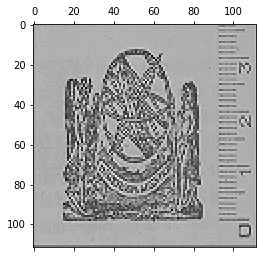

In [ ]:
img = load_img('imgs/0009492a.jpg',target_size=(224,224))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor,axis=0)
img_tensor /= 255.
img_tensor.shape

# run on the test image
activations = activation_model.predict(img_tensor)
# visualize a sample filter
first_layer_activation = activations[0]
first_layer_activation.shape
plt.matshow(first_layer_activation[0, :, :, 6], cmap='gray')
plt.show()

## Obteniendo caracteristacas en cada capa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide


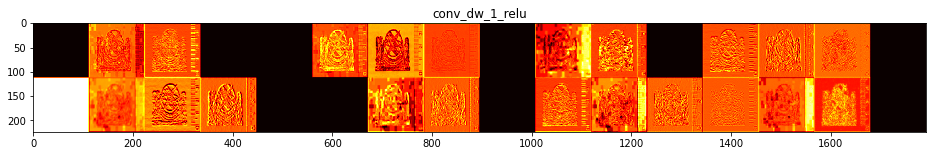

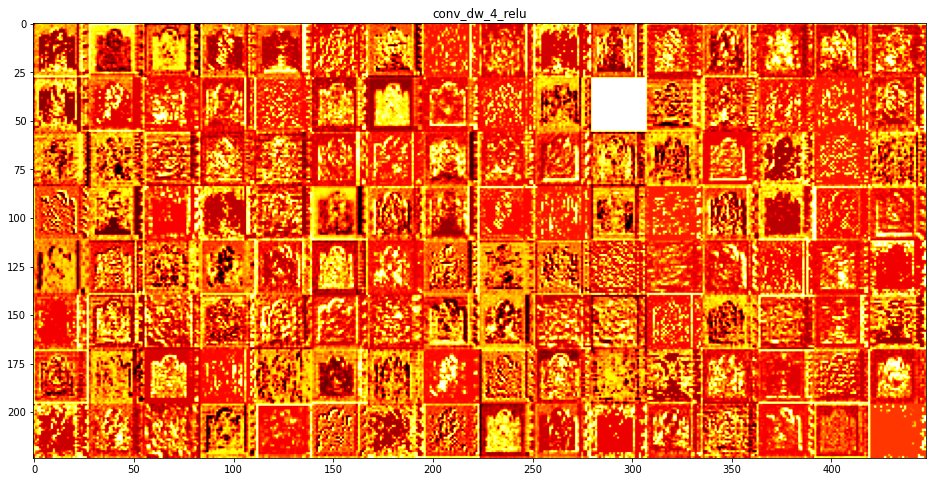

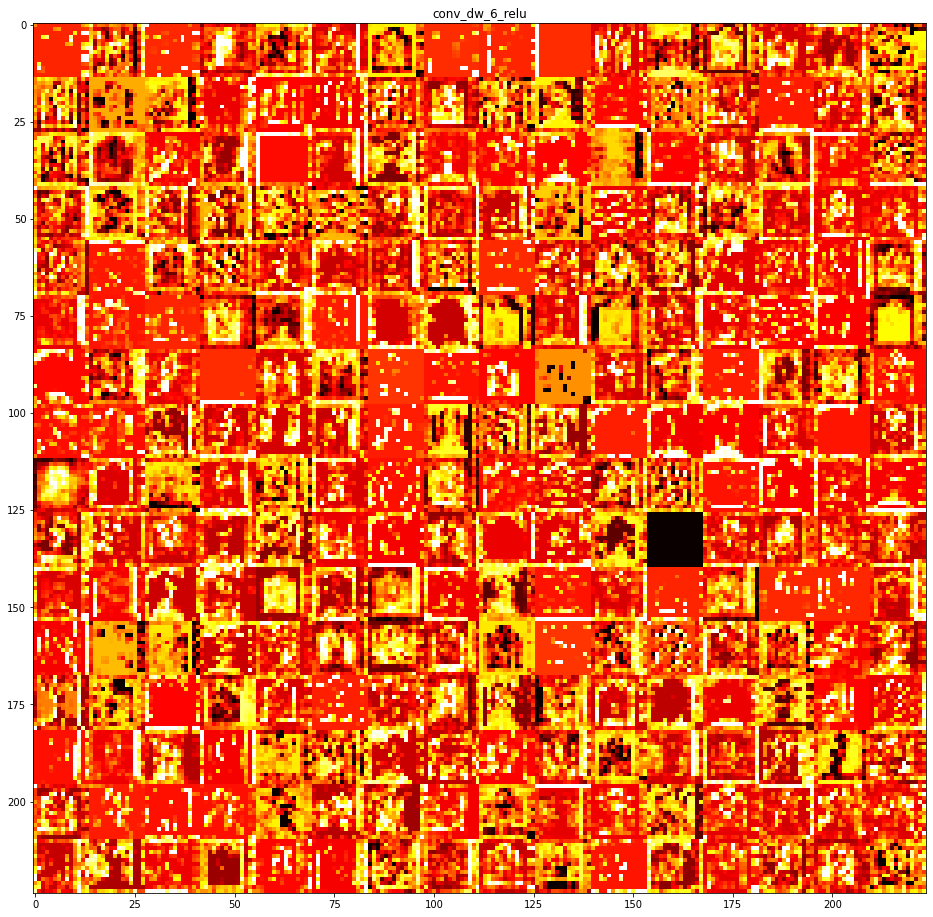

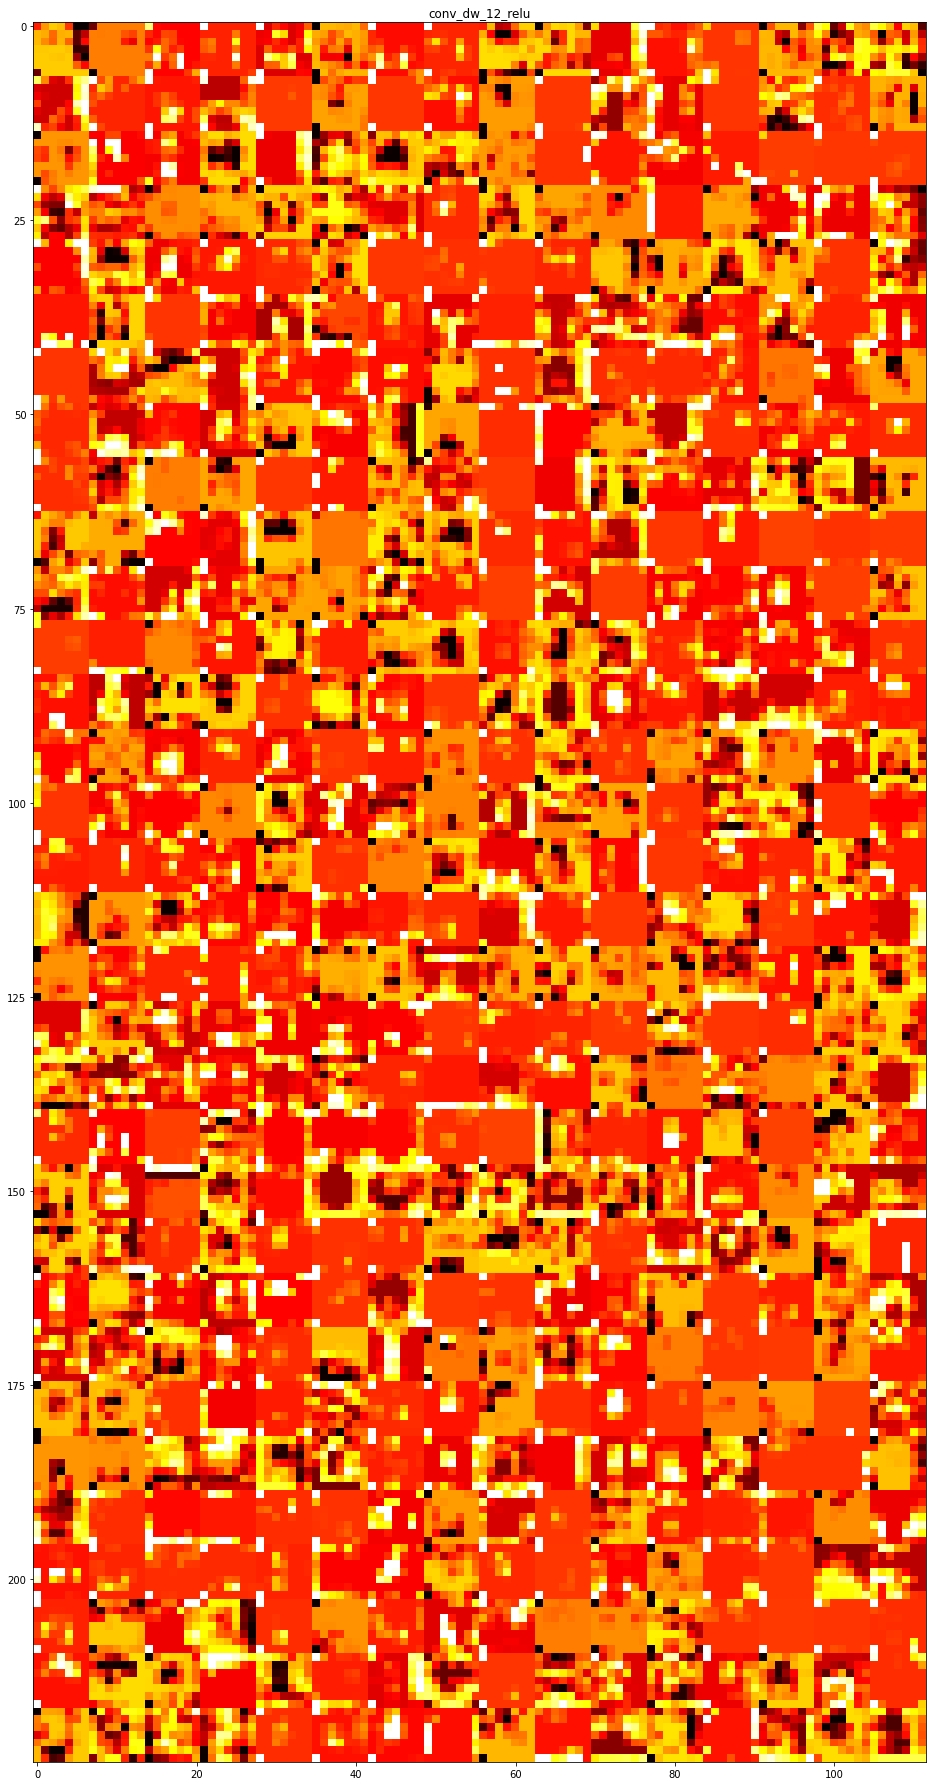

In [ ]:
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    # numero de caracteristicas
    n_features = layer_activation.shape[-1]

    # el shape del mapa de caracteristicas (1, size, size, n_features)
    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]

            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # mostramos el grid de imagenes
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='hot')
    
plt.show()

# Procesamiento de la imagen


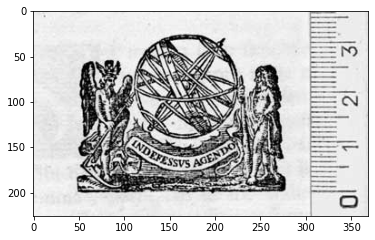

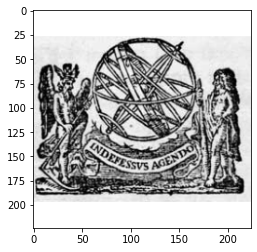

In [12]:
def image_proc(image_path):
    
    # leemos la imagen
    img = cv2.imread(image_path, 0)

    # buscamos la imagen con mayor superficie
    ret, thresh = cv2.threshold(img,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    kernel = np.ones((2,2),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 1)
    kernel = np.ones((4,4),np.uint8) # 3 - 6
    dilate = cv2.dilate(opening,kernel,iterations=3) #3
    # encontramos sus contornos
    contours, hierarchy = cv2.findContours(dilate,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

    # buscamos el area mas grande y recortamos
    mx = (0,0,0,0)
    mx_area = 0
    for cont in contours:
        x,y,w,h = cv2.boundingRect(cont)
        area = w*h
        if area > mx_area:
            mx = x,y,w,h
            mx_area = area
    x,y,w,h = mx
    img=img[y:y+h,x:x+w]

    # cambiamos el tamaño de la imagen manteniendo el aspect ratio

    desired_size = 224
    ratio = float(desired_size)/max(img.shape[:2])
    new_size = tuple([int(x*ratio) for x in img.shape[:2]])
    img = cv2.resize(img, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=[255, 255, 255])
    

    return img_as_ubyte(img)

img = cv2.imread('imgs/0009492a.jpg',0)
plt.imshow(img, cmap=plt.cm.gray)
plt.show()
img = image_proc('imgs/0009492a.jpg')
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [14]:
df = pd.read_pickle('data_processing_txt.pkl')
df.head(8)

tag       filename                    author
0    (destral, tronc)  10247993b.jpg  Dolet, Étienne 1509-1546
1   (aguila, escorpi)   0127615a.jpg        Nájera, Esteban de
2      (ancora, dofi)   0076522a.jpg  Manuzio, Paolo 1512-1574
3      (ancora, dofi)   0076522b.jpg  Manuzio, Paolo 1512-1574
4      (ancora, dofi)   0076522c.jpg  Manuzio, Paolo 1512-1574
5  (esfera, hercules)   0009492a.jpg     Blaeu, Joan 1596-1673
6  (esfera, hercules)   0009492b.jpg     Blaeu, Joan 1596-1673
7   (minerva, tolosa)   0000005a.jpg    Colomiez, Arnaud -1666

In [15]:
def save_image_proc(df, path):
    for index,row in tqdm(df.iterrows()):
        try:
            img = image_proc('imgs/'+row['filename'])
            cv2.imwrite('p_imgs/'+row['filename'][:-4]+''+str(index)+'.jpg', img)
            df.loc[index,'processed_image'] = row['filename'][:-4]+''+str(index)+'.jpg'
        except OSError as e:
            df.loc[index,'processed_image'] = ''
        except AttributeError as e:
             df.loc[index,'processed_image'] = ''
    
    empty_index = df[df['processed_image'] == ''].index
    df = df.drop(empty_index)
    df = df.reset_index(drop=True)
    df.to_pickle(path)
    return df

In [16]:
df = save_image_proc(df,'processed_image_txt.pkl')

2092it [54:11,  1.55s/it]


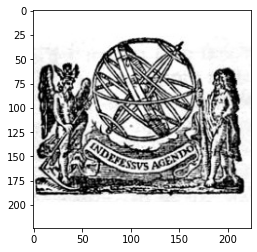

In [ ]:
img = cv2.imread('p_imgs/0009492a4.jpg')
plt.imshow(img)
plt.show()

In [ ]:
df = pd.read_pickle('processed_image_txt.pkl') 
df.head(7)

tag      filename                    author processed_image
0       (aguila,)  0127615a.jpg        Nájera, Esteban de   0127615a0.jpg
1  (ancora, dofi)  0076522a.jpg  Manuzio, Paolo 1512-1574   0076522a1.jpg
2  (ancora, dofi)  0076522b.jpg  Manuzio, Paolo 1512-1574   0076522b2.jpg
3  (ancora, dofi)  0076522c.jpg  Manuzio, Paolo 1512-1574   0076522c3.jpg
4       (esfera,)  0009492a.jpg     Blaeu, Joan 1596-1673   0009492a4.jpg
5       (esfera,)  0009492b.jpg     Blaeu, Joan 1596-1673   0009492b5.jpg
6      (minerva,)  0000005a.jpg    Colomiez, Arnaud -1666   0000005a6.jpg

 # Obtención de característica para todas las imágenes 

In [ ]:
# obtenemos el modelo que queremos
def get_model(name):
    if name == 'ResNet50':
        return applications.resnet_v2.ResNet101V2(weights='imagenet', include_top=False, pooling='avg')

    elif name == 'VGG16':
        return applications.vgg16.VGG16(weights='imagenet', include_top=False, pooling='avg')

    elif name == 'MobileNet':
        return applications.mobilenet.MobileNet(weights='imagenet', include_top=False, pooling='avg')
    
    else:
        raise ValueError('Unrecognised model: "{}"'.format(name))

In [ ]:
# extremos las caracteristicas de todas las imagenes
def extract_features(df):
    
    vgg = get_model('VGG16')
    resnet = get_model('ResNet50')
    mobilenet = get_model('MobileNet')
    df["vgg_features"] = [[] for _ in range(len(df))]
    df["resnet_features"] = [[] for _ in range(len(df))]
    df["mobilenet_features"] = [[] for _ in range(len(df))]
    
    for index,row in df.iterrows():
        
        img = load_img('p_imgs/'+row['processed_image'], target_size=(224, 224))
        img_data = img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)

        img_data_vgg = img_data.copy()
        img_data_vgg = applications.vgg16.preprocess_input(img_data_vgg)

        img_data_res = img_data.copy()
        img_data_res = applications.resnet_v2.preprocess_input(img_data_res)

        img_data_mob = img_data.copy()
        img_data_mob = applications.mobilenet.preprocess_input(img_data_mob)

        df.at[index,'vgg_features'] = vgg.predict(img_data_vgg)[0]
        df.at[index,'resnet_features'] = resnet.predict(img_data_res)[0]
        df.at[index,'mobilenet_features'] = mobilenet.predict(img_data_mob)[0]
    
    return df

df = extract_features(df)

print('VGG16 size:' , len(df['vgg_features'][0]))
print('ResNet50 size:' , len(df['resnet_features'][0]))
print('MobileNet size:' , len(df['mobilenet_features'][0]))

17227776/17225924 [==============================] - 0s 0us/step
VGG16 size: 512
ResNet50 size: 2048
MobileNet size: 1024


In [ ]:
df.head(7)

tag  ...                                 mobilenet_features
0       (aguila,)  ...  [0.1495454, 0.29908353, 0.004312407, 0.0355722...
1  (ancora, dofi)  ...  [0.03204904, 0.71795064, 0.16496207, 0.8374542...
2  (ancora, dofi)  ...  [0.049377967, 0.69437176, 0.01733708, 0.0, 3.2...
3  (ancora, dofi)  ...  [0.07315579, 0.0, 0.006026902, 0.0, 1.4178928,...
4       (esfera,)  ...  [0.6132733, 0.122206554, 0.3569663, 0.0, 0.113...
5       (esfera,)  ...  [0.43555793, 0.6272333, 1.555637, 0.28966957, ...
6      (minerva,)  ...  [0.82734376, 2.4228055, 0.29782745, 0.00106083...

[7 rows x 7 columns]

In [ ]:
df.to_pickle('all_features.pkl')
df.head(7)

tag  ...                                 mobilenet_features
0       (aguila,)  ...  [0.1495454, 0.29908353, 0.004312407, 0.0355722...
1  (ancora, dofi)  ...  [0.03204904, 0.71795064, 0.16496207, 0.8374542...
2  (ancora, dofi)  ...  [0.049377967, 0.69437176, 0.01733708, 0.0, 3.2...
3  (ancora, dofi)  ...  [0.07315579, 0.0, 0.006026902, 0.0, 1.4178928,...
4       (esfera,)  ...  [0.6132733, 0.122206554, 0.3569663, 0.0, 0.113...
5       (esfera,)  ...  [0.43555793, 0.6272333, 1.555637, 0.28966957, ...
6      (minerva,)  ...  [0.82734376, 2.4228055, 0.29782745, 0.00106083...

[7 rows x 7 columns]

In [4]:
df = pd.read_pickle('all_features.pkl') 
df.head(7)

tag  ...                                 mobilenet_features
0       (aguila,)  ...  [0.1495454, 0.29908353, 0.004312407, 0.0355722...
1  (ancora, dofi)  ...  [0.03204904, 0.71795064, 0.16496207, 0.8374542...
2  (ancora, dofi)  ...  [0.049377967, 0.69437176, 0.01733708, 0.0, 3.2...
3  (ancora, dofi)  ...  [0.07315579, 0.0, 0.006026902, 0.0, 1.4178928,...
4       (esfera,)  ...  [0.6132733, 0.122206554, 0.3569663, 0.0, 0.113...
5       (esfera,)  ...  [0.43555793, 0.6272333, 1.555637, 0.28966957, ...
6      (minerva,)  ...  [0.82734376, 2.4228055, 0.29782745, 0.00106083...

[7 rows x 7 columns]

In [5]:
print(len(df['vgg_features'][0]))
print(len(df['resnet_features'][0]))
print(len(df['mobilenet_features'][0]))

512
2048
1024


# Normalización de vectores

In [6]:
from sklearn.preprocessing import normalize

df["vgg_features_norm"] = [[] for _ in range(len(df))]
df["resnet_features_norm"] = [[] for _ in range(len(df))]
df["mobilenet_features_norm"] = [[] for _ in range(len(df))]

# Norm
vgg_norm = [normalize(np.array(x).astype(np.float)[:,np.newaxis], axis=0).ravel() for x in df['vgg_features'].to_numpy()]
resnet_norm = [normalize(np.array(x).astype(np.float)[:,np.newaxis], axis=0).ravel() for x in df['resnet_features'].to_numpy()]
mobilenet_norm = [normalize(np.array(x).astype(np.float)[:,np.newaxis], axis=0).ravel() for x in df['mobilenet_features'].to_numpy()]

df['vgg_features_norm'] = vgg_norm
df['resnet_features_norm'] = resnet_norm
df['mobilenet_features_norm'] = mobilenet_norm

df.head()

tag  ...                            mobilenet_features_norm
0       (aguila,)  ...  [0.00466050236847265, 0.009320778116230444, 0....
1  (ancora, dofi)  ...  [0.0011868891589065294, 0.02658824728423094, 0...
2  (ancora, dofi)  ...  [0.0015717581981214723, 0.022102661970655132, ...
3  (ancora, dofi)  ...  [0.0026603194537203126, 0.0, 0.000219169035028...
4       (esfera,)  ...  [0.02208458647947665, 0.004400780380861736, 0....

[5 rows x 10 columns]

# K vecinos más cercanos (KNN)

In [7]:
!pip install annoy

     |████████████████████████████████| 645kB 2.6MB/s eta 0:00:01
  Created wheel for annoy: filename=annoy-1.16.3-cp36-cp36m-linux_x86_64.whl size=297341 sha256=e3b44083af75207724250d35e7bffa525d29a4da3ccb2896a2864ddab3f0594f
  Stored in directory: /root/.cache/pip/wheels/f3/01/54/6ef760fe9f9fc6ba8c19cebbe6358212b5f3b5b0195c0b813f
Successfully built annoy


In [8]:
from annoy import AnnoyIndex

t_vgg = AnnoyIndex(len(df['vgg_features_norm'][0]), metric='euclidean')
t_resnet = AnnoyIndex(len(df['resnet_features_norm'][0]), metric='euclidean')
t_mobilenet = AnnoyIndex(len(df['mobilenet_features_norm'][0]), metric='euclidean')

for index,row in df.iterrows():
    t_vgg.add_item(index, row['vgg_features_norm'])
    t_resnet.add_item(index, row['resnet_features_norm'])
    t_mobilenet.add_item(index, row['mobilenet_features_norm'])

_  = t_vgg.build(500)
_  = t_resnet.build(500)
_ = t_mobilenet.build(500)

# Imágenes similares

In [9]:
def similar_by_tag(df, img_index):
    tags = df.iloc[img_index]['tag']
    true_sim = df['tag'].apply(lambda tag: len([x for x in tag if x in tags])).to_frame()
    imgs_index = true_sim[true_sim.tag >= 1].index.tolist()
    imgs_index.remove(img_index)
    return imgs_index

In [10]:
def show_similar_images(df, img_index, num, nn, show=True):
    
    img_tags = df.iloc[img_index]['tag']
    tag_similar = similar_by_tag(df, img_index)
    original  = df.iloc[img_index]['processed_image']
    similar_img_ids = nn.get_nns_by_item(img_index, num+1)
    
    if img_index in similar_img_ids: similar_img_ids.remove(img_index)
    similar,  master_vector = df.iloc[similar_img_ids].copy(), df.iloc[img_index].copy()

    
    if show:
        plt.figure(figsize=(20,20)) 
        grid = round(math.sqrt(num))+1
        img = cv2.imread('/content/drive/My Drive/p_imgs/'+original)
        ax = plt.subplot(grid,grid,1)
        plt.subplots_adjust(bottom = 0.1)
        ax.set_title(str('Similar ' + str(master_vector[0])))
        plt.imshow(img, cmap='gray')


    row_index = 1
    retrived = similar.index.tolist()

    sum_ap = 0
    hit = 0

    for index, row in similar.iterrows():
        
        title = str(index)
        if index in tag_similar:
            hit+=1
            PaK = (hit/row_index)
            title += ' PaK: ' + str(PaK)
            sum_ap += PaK

        if show:
            img = cv2.imread('/content/drive/My Drive/p_imgs/'+row['processed_image'])
            ax = plt.subplot(grid,grid,row_index+1)
            ax.set_title(title + '\n' + str(row['tag'])) 
            plt.imshow(img, cmap='gray')

        row_index+=1;
        
    plt.show()
    return sum_ap/len(retrived)

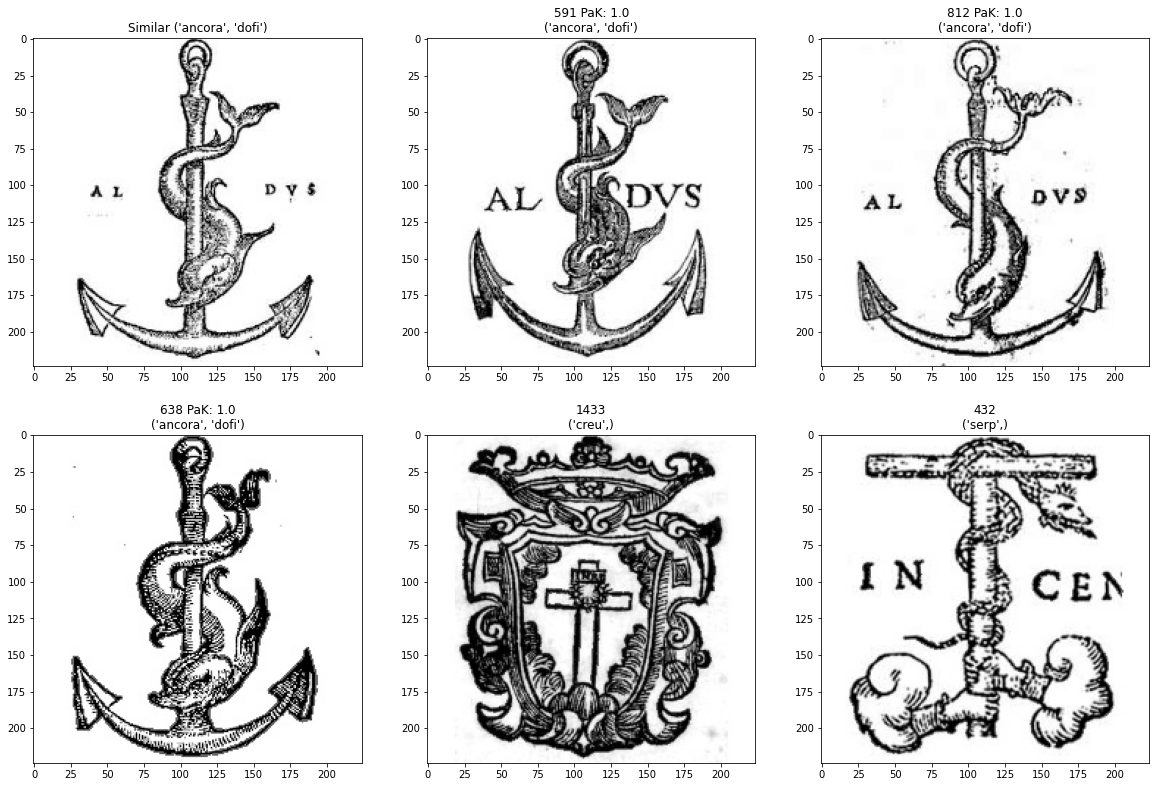

0.6

In [ ]:
show_similar_images(df, 1, 5, t_vgg)

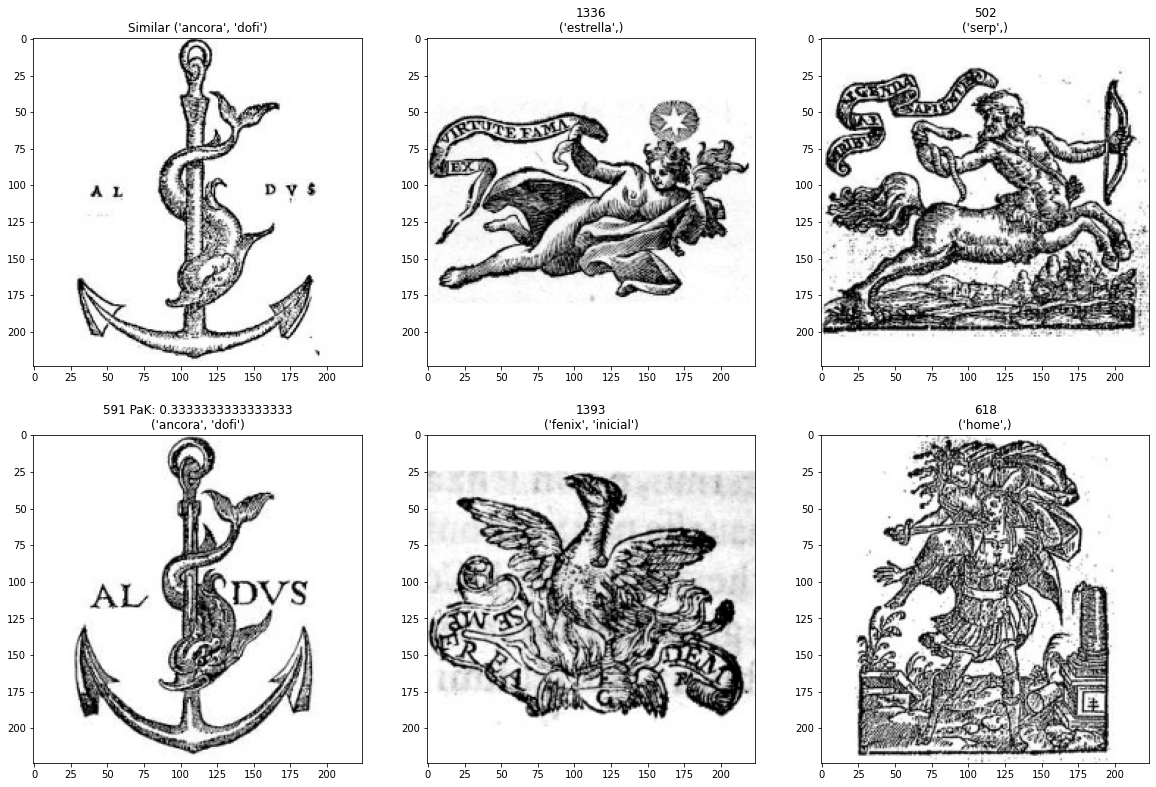

0.06666666666666667

In [ ]:
show_similar_images(df, 1, 5, t_resnet)

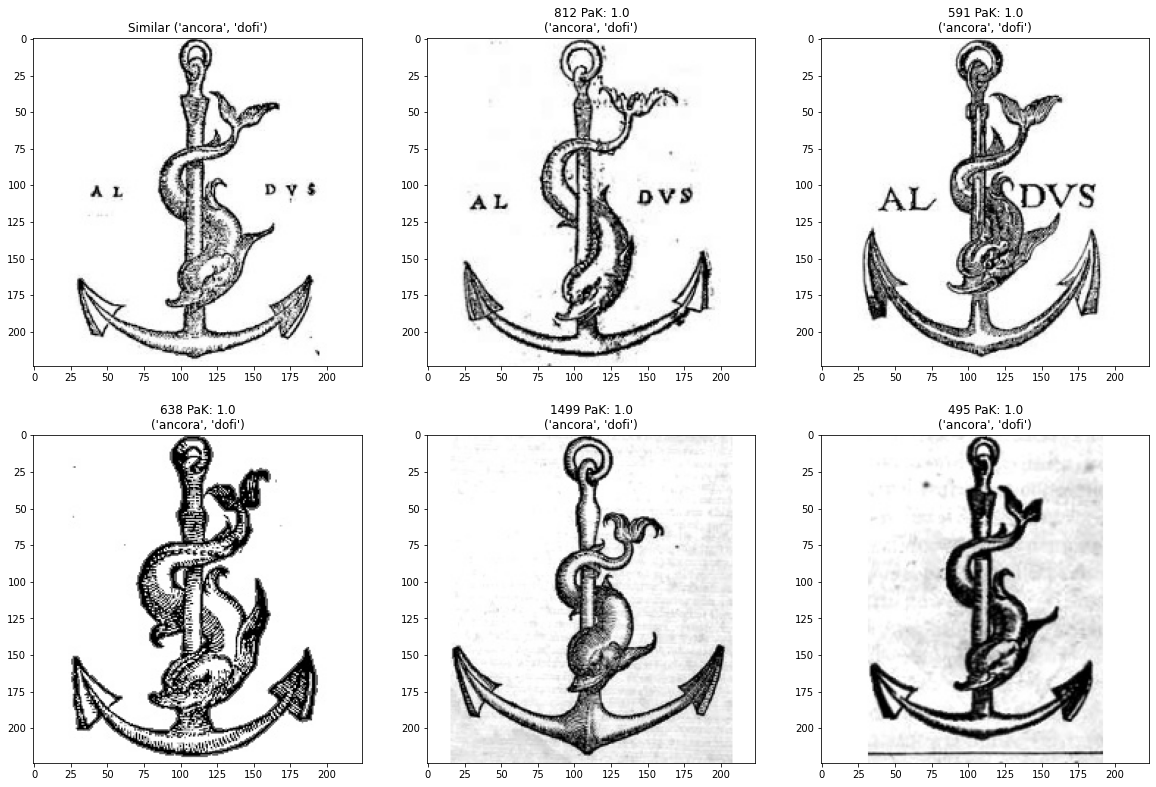

1.0

In [ ]:
show_similar_images(df, 1, 5, t_mobilenet)

{'k-1': 0.42, 'k-3': 0.31, 'k-5': 0.26, 'k-10': 0.19}


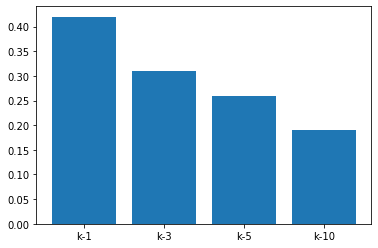

{'k-1': 0.41, 'k-3': 0.3, 'k-5': 0.24, 'k-10': 0.18}


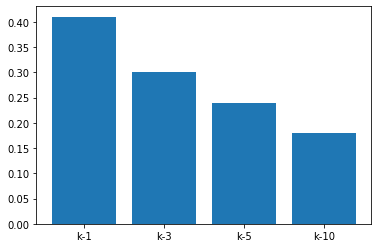

{'k-1': 0.46, 'k-3': 0.35, 'k-5': 0.29, 'k-10': 0.22}


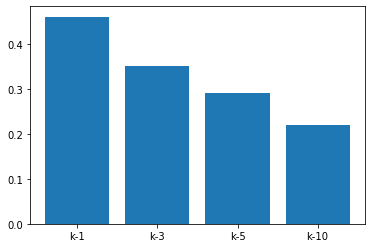

In [ ]:
def show_map_models(df, models):
    test_index = df.index.tolist()
    for model in models:
        total = {}
        for k in [1,3,5,10]:
            aps = []
            for index in test_index:
                aps.append(show_similar_images(df, index, k, model, False))
            total['k-'+str(k)] = round(np.mean(aps), 2)
        print(total)
        plt.bar(range(len(total)), list(total.values()), align='center')
        plt.xticks(range(len(total)), list(total.keys()))
        plt.show()


show_map_models(df, [t_vgg, t_resnet, t_mobilenet])

In [ ]:
print(len(df))

1512


# Imagenes con tags de baja respuesta


33
['sirena', 'estrella', 'dona', 'flama', 'fenix', 'pau', 'sol', 'arbre', 'sant', 'jesucrist', 'salamandra', 'angel', 'mercuri', 'llibre', 'ma', 'cigonya', 'home', 'aguila', 'olivera', 'vaixell', 'compas', 'serp', 'corona', 'escut', 'caduceu', 'putto', 'fortuna', 'lleo', 'inicial', 'cornucopia', 'griu', 'minerva', 'globus']


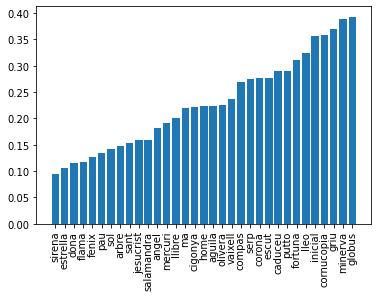

36
['sirena', 'dona', 'estrella', 'vaixell', 'home', 'fenix', 'mercuri', 'sol', 'sant', 'flama', 'llibre', 'jesucrist', 'angel', 'salamandra', 'ma', 'aguila', 'fortuna', 'cigonya', 'caduceu', 'arbre', 'pau', 'olivera', 'lleo', 'serp', 'escut', 'minerva', 'corona', 'compas', 'putto', 'cornucopia', 'abella', 'inicial', 'pegas', 'griu', 'esfera', 'flor']


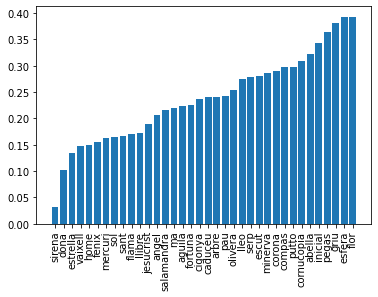

29
['fenix', 'estrella', 'pau', 'dona', 'sirena', 'jesucrist', 'flama', 'sol', 'sant', 'salamandra', 'angel', 'arbre', 'cigonya', 'llibre', 'aguila', 'ma', 'putto', 'home', 'mercuri', 'lleo', 'fortuna', 'serp', 'caduceu', 'corona', 'escut', 'vaixell', 'olivera', 'compas', 'cornucopia']


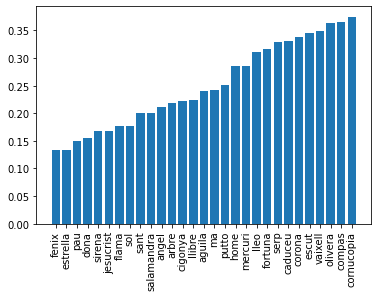

In [ ]:
tags = list(set(np.hstack(df['tag'].to_numpy()).flatten()))

models = [t_vgg, t_resnet, t_mobilenet]

def show_tags_acc(df, limit, models, mode='less'):
    for model in models:
      res = {}
      for tag in tags:
        aps = []
        mask = df['tag'].apply(lambda t: tag in t)
        imgs_index = df[mask].index.tolist()
        for index in imgs_index:
              aps.append(show_similar_images(df, index, 5, model, False))
        temp = np.mean(aps)
        if mode == 'less':
            if temp < limit:
              res[tag] = temp
        if mode == 'greater':
            if temp >= limit:
              res[tag] = temp

      res = {k: v for k, v in sorted(res.items(), key=lambda item: item[1])}
      print(len(list(res.keys())))
      print(list(res.keys()))
      plt.bar(range(len(res)), list(res.values()), align='center')
      plt.xticks(range(len(res)), list(res.keys()), rotation=90)
      plt.show()

show_tags_acc(df, 0.4, models)

10
['flor', 'esfera', 'creu', 'abella', 'lis', 'ancora', 'pegas', 'monograma', 'dofi', 'cercle']


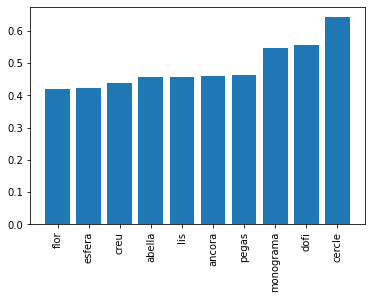

7
['globus', 'ancora', 'lis', 'creu', 'dofi', 'monograma', 'cercle']


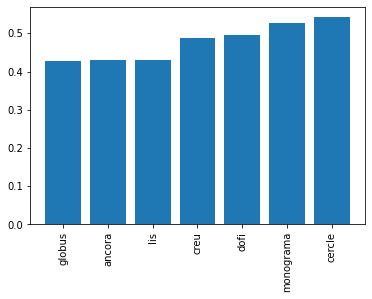

14
['inicial', 'esfera', 'minerva', 'flor', 'abella', 'griu', 'creu', 'lis', 'pegas', 'globus', 'monograma', 'ancora', 'cercle', 'dofi']


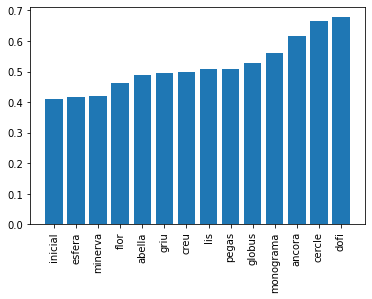

In [ ]:
show_tags_acc(df, 0.4, models, 'greater')

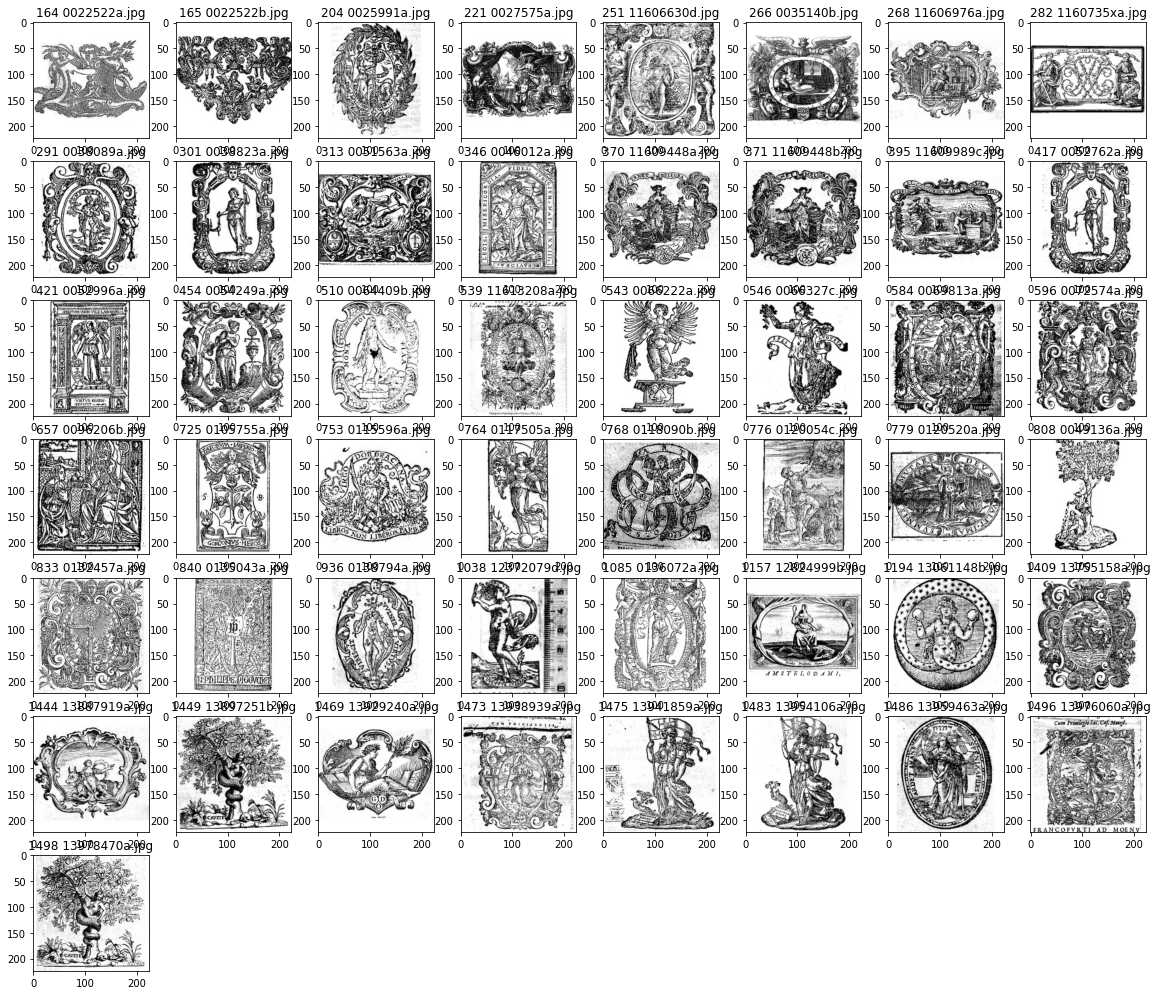

In [ ]:
def show_images_by_tag(df, tag):
    plt.figure(figsize=(20,20)) 
    imgs = []
    name = []
    idxs = []
    for index,row in df.iterrows():
        if tag in list(row['tag']):
            imgs.append(cv2.imread('p_imgs/'+row['processed_image']))
            name.append(row['filename'])
            idxs.append(index)
    grid = round(math.sqrt(len(imgs)))+1
    for i in range(len(imgs)):
          ax = plt.subplot(grid,grid,i+1)
          ax.set_title(str(idxs[i]) + ' ' + name[i])
          plt.imshow(imgs[i])
    plt.show()

show_images_by_tag(df, 'dona')

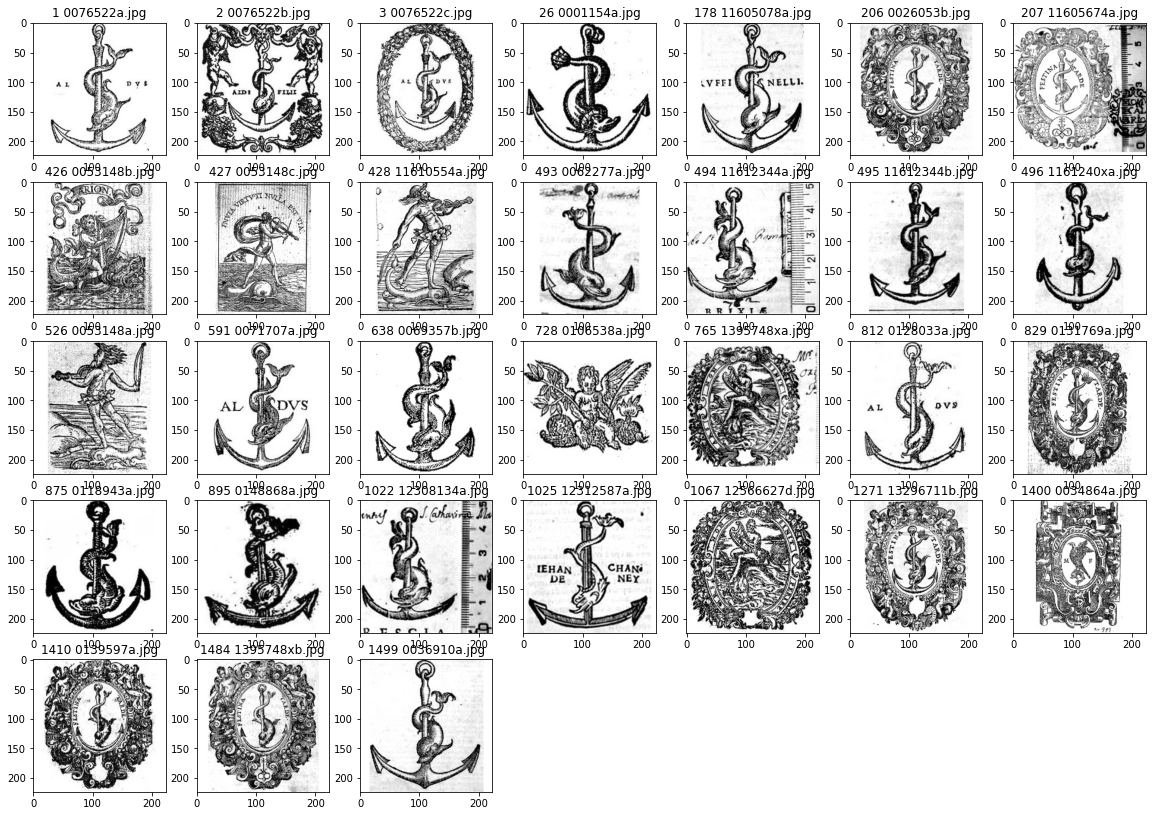

In [ ]:
show_images_by_tag(df, 'dofi')

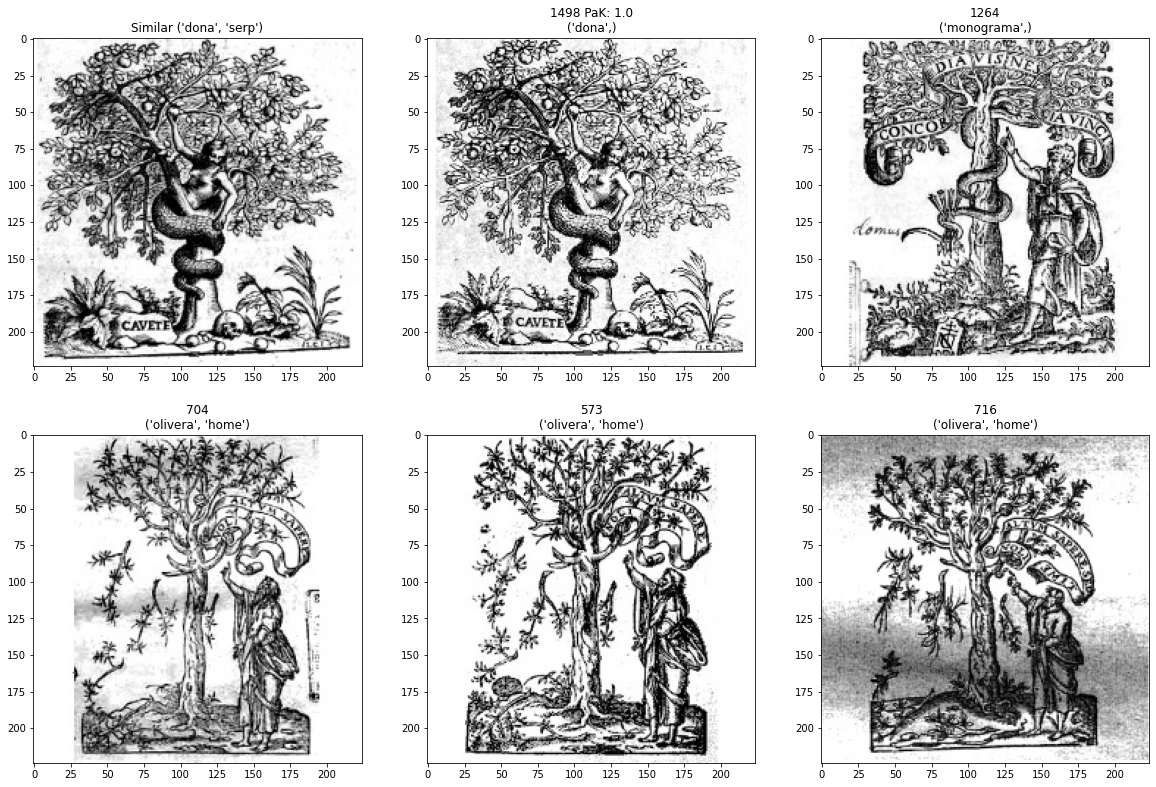

0.2

In [ ]:
show_similar_images(df, 1449, 5, t_mobilenet)

Eliminamos los tags irrelevantes para hacer un fine-tuning de MobileNet y ver si podemos obtener mejores resultados

In [ ]:
tags_low_res = ['fenix', 'estrella', 'pau', 'dona', 'sirena', 'jesucrist', 'flama', 'sol', 'sant', 'salamandra', 'angel', 'arbre', 'cigonya', 'llibre', 'aguila', 'ma', 'putto', 'home', 'mercuri', 'lleo', 'fortuna', 'serp', 'caduceu', 'corona', 'escut', 'vaixell', 'olivera', 'compas', 'cornucopia']
remove_index = df['tag'].apply(lambda x: len([t for t in x if t in tags_low_res])).to_frame()
remove_index = remove_index[remove_index.tag >= 1].index.tolist()
print(remove_index)
df_to_pretrain = pd.read_pickle('processed_image_txt.pkl') 
df_to_pretrain.drop(remove_index, inplace=True)
df_to_pretrain.reset_index(inplace=True)
df_to_pretrain.to_pickle('processed_image_txt_pretrain.pkl')

[0, 8, 9, 10, 12, 13, 15, 17, 18, 20, 23, 24, 25, 27, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 45, 46, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 66, 67, 68, 69, 74, 75, 76, 77, 78, 80, 81, 82, 83, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 105, 106, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 129, 132, 133, 134, 135, 136, 137, 138, 140, 141, 143, 144, 145, 146, 148, 150, 151, 152, 154, 155, 157, 161, 162, 163, 164, 165, 166, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177, 179, 180, 184, 185, 186, 191, 192, 193, 200, 202, 203, 204, 205, 208, 209, 210, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 223, 225, 226, 227, 228, 229, 231, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 244, 245, 246, 249, 250, 251, 252, 253, 254, 255, 256, 258, 259, 260, 261, 262, 265, 266, 267, 268, 271, 272, 274, 275, 276, 277, 282, 285, 286, 287, 288, 289, 290, 291, 292, 293, 295, 296, 297, 298, 299, 301, 306, 307, 308, 309, 310, 311, 

In [ ]:
df_to_pretrain.head()

index             tag  ...                    author processed_image
0      1  (ancora, dofi)  ...  Manuzio, Paolo 1512-1574   0076522a1.jpg
1      2  (ancora, dofi)  ...  Manuzio, Paolo 1512-1574   0076522b2.jpg
2      3  (ancora, dofi)  ...  Manuzio, Paolo 1512-1574   0076522c3.jpg
3      4       (esfera,)  ...     Blaeu, Joan 1596-1673   0009492a4.jpg
4      5       (esfera,)  ...     Blaeu, Joan 1596-1673   0009492b5.jpg

[5 rows x 5 columns]

In [ ]:
df.drop(remove_index, inplace=True)
df.reset_index(inplace=True)
df.head()

index  ...                            mobilenet_features_norm
0      1  ...  [0.0011868891589065294, 0.02658824728423094, 0...
1      2  ...  [0.0015717581981214723, 0.022102661970655132, ...
2      3  ...  [0.0026603194537203126, 0.0, 0.000219169035028...
3      4  ...  [0.02208458647947665, 0.004400780380861736, 0....
4      5  ...  [0.013071170533633126, 0.018823383018038452, 0...

[5 rows x 11 columns]

{'k-1': 0.69, 'k-3': 0.59, 'k-5': 0.53, 'k-10': 0.47}


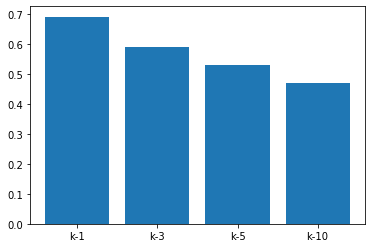

{'k-1': 0.68, 'k-3': 0.57, 'k-5': 0.53, 'k-10': 0.46}


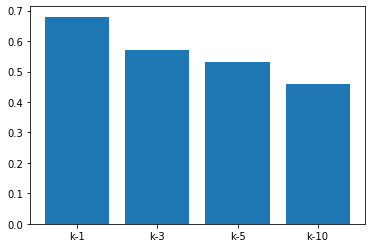

{'k-1': 0.71, 'k-3': 0.63, 'k-5': 0.58, 'k-10': 0.51}


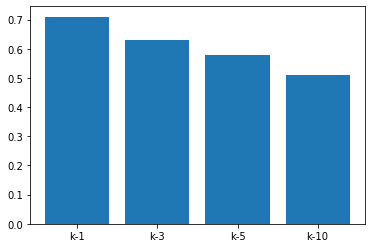

In [ ]:
t_vgg = AnnoyIndex(len(df['vgg_features'][0]), metric='euclidean')
t_resnet = AnnoyIndex(len(df['resnet_features'][0]), metric='euclidean')
t_mobilenet = AnnoyIndex(len(df['mobilenet_features'][0]), metric='euclidean')

for index,row in df.iterrows():
    t_vgg.add_item(index, row['vgg_features_norm'])
    t_resnet.add_item(index, row['resnet_features_norm'])
    t_mobilenet.add_item(index, row['mobilenet_features_norm'])

_  = t_vgg.build(500)
_  = t_resnet.build(500)
_ = t_mobilenet.build(500)

show_map_models(df, [t_vgg, t_resnet, t_mobilenet])

## Post Fine-tuning

Despues de realizar el fine-tuning comprobamos los resultados de este modelo modificado con los tags mas relevantes y luego probamos si nos da un mejor resultado global

In [27]:
df = pd.read_pickle('processed_image_txt.pkl')  
df.head(7)

tag       filename                    author processed_image
0    (destral, tronc)  10247993b.jpg  Dolet, Étienne 1509-1546  10247993b0.jpg
1   (aguila, escorpi)   0127615a.jpg        Nájera, Esteban de   0127615a1.jpg
2      (ancora, dofi)   0076522a.jpg  Manuzio, Paolo 1512-1574   0076522a2.jpg
3      (ancora, dofi)   0076522b.jpg  Manuzio, Paolo 1512-1574   0076522b3.jpg
4      (ancora, dofi)   0076522c.jpg  Manuzio, Paolo 1512-1574   0076522c4.jpg
5  (esfera, hercules)   0009492a.jpg     Blaeu, Joan 1596-1673   0009492a5.jpg
6  (esfera, hercules)   0009492b.jpg     Blaeu, Joan 1596-1673   0009492b6.jpg

In [24]:
from keras.layers import GlobalAveragePooling2D
def extract_features(df):
    
    model = models.load_model('final_model.h5')
    test = GlobalAveragePooling2D()(model.layers[-4].output)
    model = Model(inputs=model.inputs, outputs=test)
    df["fine_features"] = [[] for _ in range(len(df))]
    
    for index,row in df.iterrows():

        
        img = load_img('p_imgs/'+row['processed_image'], target_size=(224, 224))
        img_data = img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data_mob = applications.mobilenet.preprocess_input(img_data)

        df.at[index,'fine_features'] = model.predict(img_data_mob)[0]
    
    return df
df =  extract_features(df)
df.to_pickle('fine_features.pkl')
df.head()

tag  ...                                      fine_features
0   (destral, tronc)  ...  [0.88577706, 0.42388988, 0.058556892, 0.649012...
1  (aguila, escorpi)  ...  [0.2131083, 0.04766954, 0.22137304, 0.23495254...
2     (ancora, dofi)  ...  [0.17396754, 0.87703305, 0.19467866, 0.9052245...
3     (ancora, dofi)  ...  [0.03111152, 0.68502605, 0.28720248, 0.1255729...
4     (ancora, dofi)  ...  [0.10229269, 0.0, 0.11129687, 0.27967206, 0.55...

[5 rows x 5 columns]

In [101]:
df = pd.read_pickle('fine_features.pkl') 
df.head()

tag  ...                                      fine_features
0   (destral, tronc)  ...  [0.88577706, 0.42388988, 0.058556892, 0.649012...
1  (aguila, escorpi)  ...  [0.2131083, 0.04766954, 0.22137304, 0.23495254...
2     (ancora, dofi)  ...  [0.17396754, 0.87703305, 0.19467866, 0.9052245...
3     (ancora, dofi)  ...  [0.03111152, 0.68502605, 0.28720248, 0.1255729...
4     (ancora, dofi)  ...  [0.10229269, 0.0, 0.11129687, 0.27967206, 0.55...

[5 rows x 5 columns]

In [103]:
df["fine_features_norm"] = [[] for _ in range(len(df))]

fine_norm = [normalize(np.array(x).astype(np.float)[:,np.newaxis], axis=0).ravel() for x in df['fine_features'].to_numpy()]

df['fine_features_norm'] = fine_norm

t_fine = AnnoyIndex(len(df['fine_features_norm'][0]), metric='euclidean')

for index,row in df.iterrows():
    t_fine.add_item(index, row['fine_features_norm'])

_  = t_fine.build(500)
t_fine.save('index.annoy')

True

{'k-1': 0.5, 'k-3': 0.37, 'k-5': 0.31, 'k-10': 0.24}


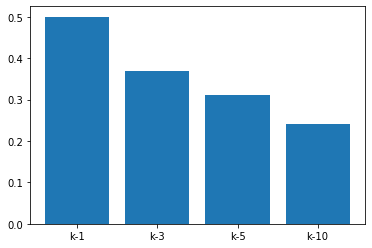

In [ ]:
def show_map_models(df, models):
    test_index = df.index.tolist()
    for model in models:
        total = {}
        for k in [1,3,5,10]:
            aps = []
            for index in test_index:
                aps.append(show_similar_images(df, index, k, model, False))
            total['k-'+str(k)] = round(np.mean(aps), 2)
        print(total)
        plt.bar(range(len(total)), list(total.values()), align='center')
        plt.xticks(range(len(total)), list(total.keys()))
        plt.show()
show_map_models(df, [t_fine])

{'k-1': 0.74, 'k-3': 0.66, 'k-5': 0.61, 'k-10': 0.53}


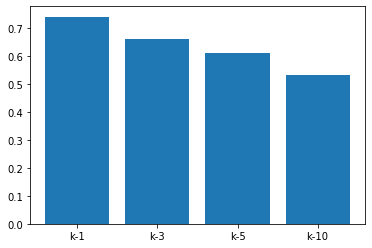

In [ ]:
tags_low_res = ['fenix', 'estrella', 'pau', 'dona', 'sirena', 'jesucrist', 'flama', 'sol', 'sant', 'salamandra', 'angel', 'arbre', 'cigonya', 'llibre', 'aguila', 'ma', 'putto', 'home', 'mercuri', 'lleo', 'fortuna', 'serp', 'caduceu', 'corona', 'escut', 'vaixell', 'olivera', 'compas', 'cornucopia']
remove_index = df['tag'].apply(lambda x: len([t for t in x if t in tags_low_res])).to_frame()
remove_index = remove_index[remove_index.tag >= 1].index.tolist()
df.drop(remove_index, inplace=True)
df.reset_index(inplace=True)

t_fine = AnnoyIndex(len(df['fine_features_norm'][0]), metric='euclidean')

for index,row in df.iterrows():
    t_fine.add_item(index, row['fine_features_norm'])

_  = t_fine.build(500)

show_map_models(df, [t_fine])